# Recurrent networks

The following is based on Francois Chollet's excellent Deep Learning with Python.

Pseudocode for an RNN is provided briefly below. The input to an RNN is a sequence of vectors, which is encoded as a 2D tensor of size `(timesteps, input_features)`. The recurrent network loops over timesteps, and at each timestep considers the current state at time `t` as well as the input at time `t` (with shape `(input_features,)`) and combines them to form the output at time `t`. The state for the next step is then set to be this previous output.
```python
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

More precisely, the transformation in the recurrent network would take the familiar form of multiplication by weight matrices, together with the addition of a bias term and the application of a nonlinear activation function.
```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

The following is a naive Numpy implementation of a recurrent network:

In [32]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
successive_outputs_reshaped = [output.reshape((1,-1)) for 
                               output in successive_outputs]
final_output_sequence = np.concatenate(successive_outputs_reshaped,
                                       axis=0)
print(final_output_sequence.shape)

(100, 64)


In its most basic form, then a recurrent network is a `for` loop that reuses quantities computed during the previous iteration of the loop. The above naive numpy implementation corresponds to the Keras `SimpleRNN` layer.

All recurrent layers in keras can be run in two different modes: either returning the full sequences of successive outputs for each timestep `(batch_size, timesteps, output_features)` or only the last output for each input sequence `(batch_size, output_features)`. These two modes are controlled by the `return_sequences` constructor arguments for the layers.

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Using TensorFlow backend.
/home/tim/.pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


This simple recurrent network can be applied to the IMDB movie review classification problem.

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(f'train sequence length: {len(input_train)}')
print(f'test sequence length: {len(input_test)}')
print('Tokenized review vector example:')
print(input_train[0])

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print(f'input_train shape: {input_train.shape}')
print(f'input_test shape: {input_test.shape}')

train sequence length: 25000
test sequence length: 25000
Tokenized review vector example:
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 3

In [4]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=10,
                   batch_size=128, 
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.6457 - acc: 0.6089 - val_loss: 0.5288 - val_acc: 0.7592
Epoch 2/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.4183 - acc: 0.8179 - val_loss: 0.5046 - val_acc: 0.7838
Epoch 3/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.3092 - acc: 0.8758 - val_loss: 0.4723 - val_acc: 0.7738
Epoch 4/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.2426 - acc: 0.9055 - val_loss: 0.3886 - val_acc: 0.8328
Epoch 5/10
20000/20000 [==============================] - 20s 1ms/step - loss: 0.1784 - acc: 0.9339 - val_loss: 0.3558 - val_acc: 0.8656
Epoch 6/10
20000/20000 [==============================] - 20s 999us/step - loss: 0.1192 - acc: 0.9593 - val_loss: 0.3856 - val_acc: 0.8632
Epoch 7/10
20000/20000 [==============================] - 20s 999us/step - loss: 0.0800 - acc: 0.9747 - val_loss: 0.4587 - val_

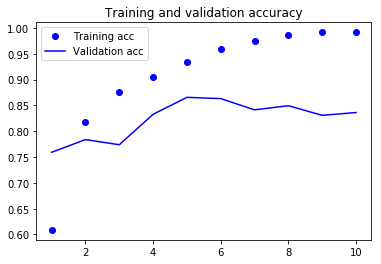

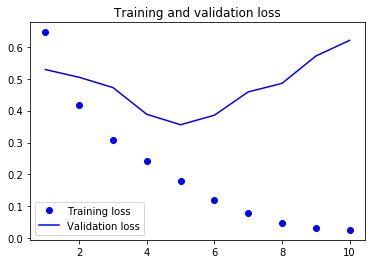

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


def show_plots(acc, val_acc, loss, val_loss):
    """
    Utility function to plot training and validation losses and accuracies.
    
    Keyword arguments:
    :acc list: training accuracy readings
    :val_acc list: validation accuracy readings
    :loss list: training loss readings
    :val list: validation loss readings
    """
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

show_plots(acc, val_acc, loss, val_loss)

The performance of this small recurrent network is not competitive with state of the art results. The fact that the model inputs contain only the first 500 inputs as opposed to the full sequences is part of the problem. However, a significant contributor is also the simple fact that `SimpleRNN` cells aren't good at learning long sequences. It suffers from the vanishing gradient problem, which makes long-term dependences intractable to learn. 

Below you see the effects of applying a sigmoid function over and over again. The data is flattened until, for large stretches, it has no detectable slope. This is analogous to a gradient vanishing as it passes through many layers.

<div style="display:block;margin:auto;width:500px;">
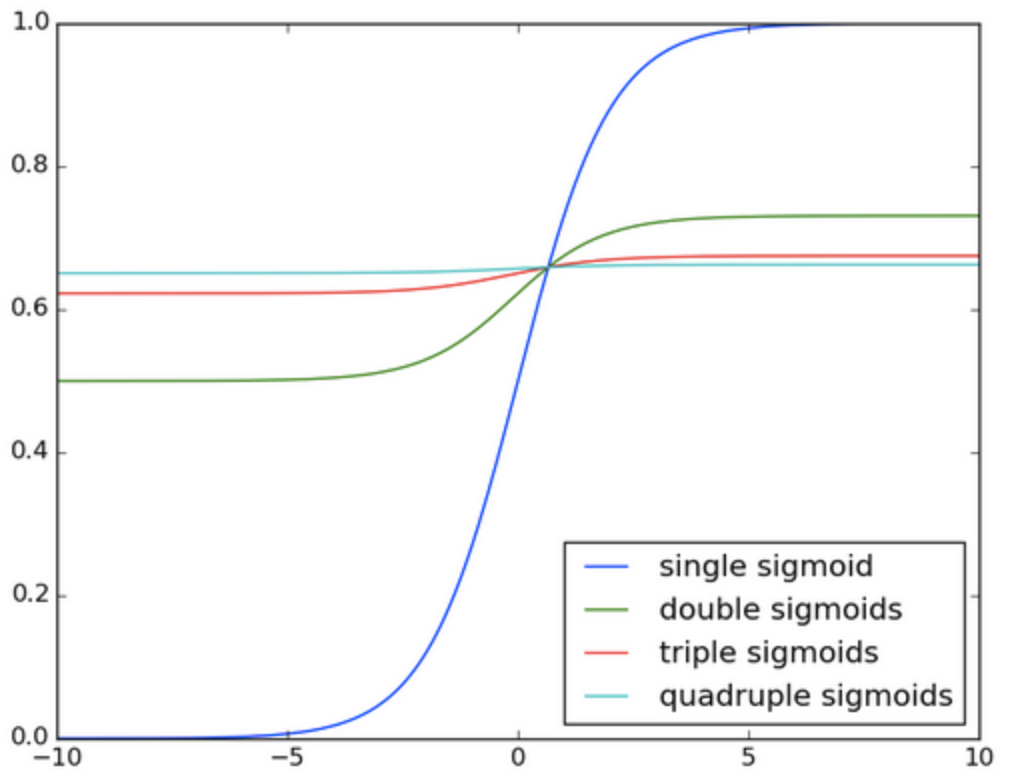
</div>
<div style="text-align:center;">**Vanishing Gradients**</div>

`LSTM` and `GRU` layers deal with this problem.

In particular, the `LSTM` cell saves information to carry across timesteps, preventing signals from vanishing during training. The `LSTM` cell achieves this through adding an additional data flow that carries information across timesteps. This information is combined with the input connection and the recurrent connection, affecting the state being sent to the next timestep.

<div style="display:block;margin:auto;width:800px;">
    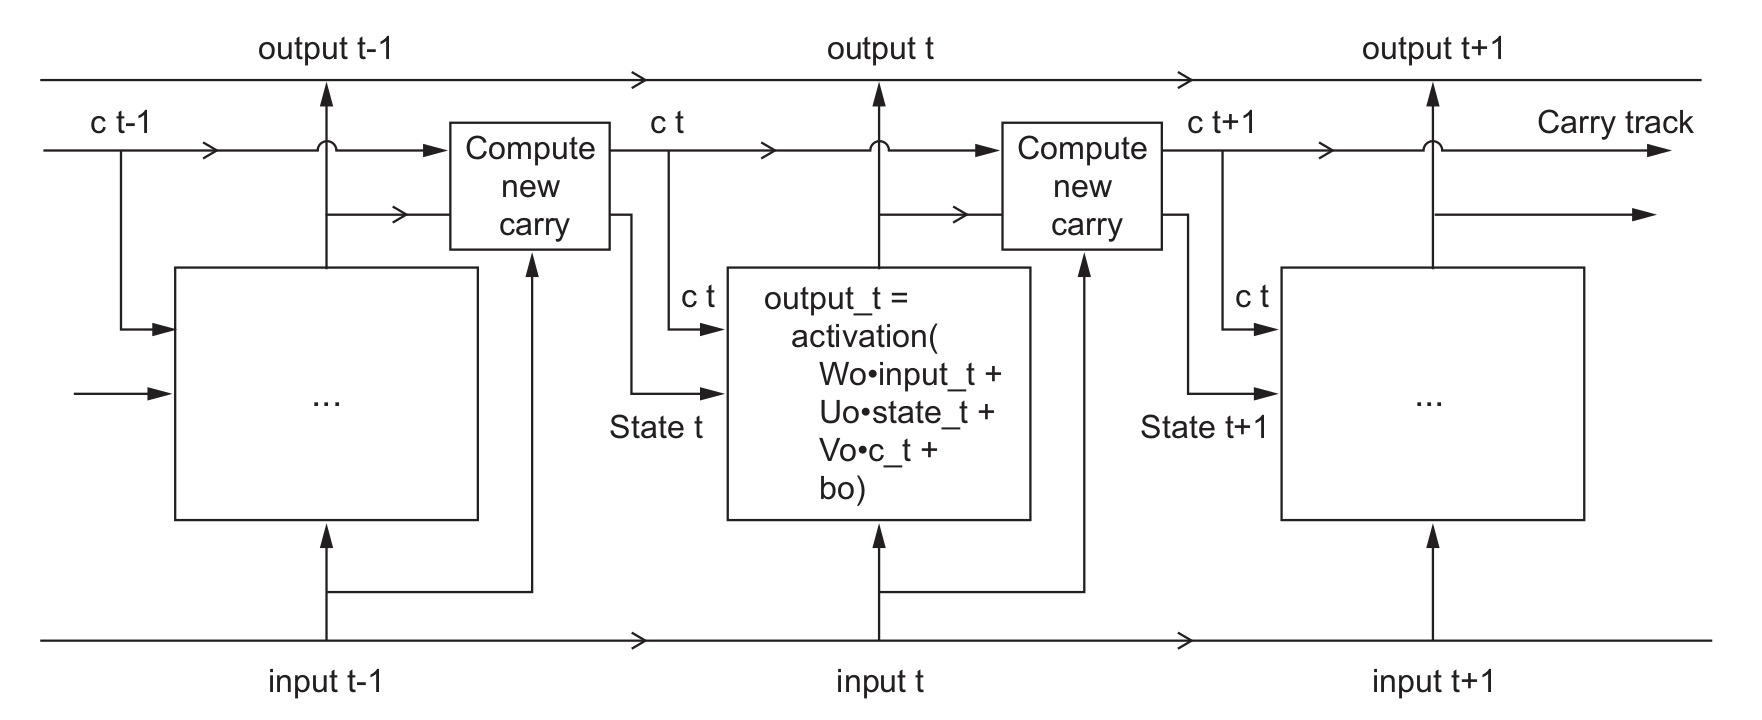
</div>
<div style="text-align:center;">**LSTM Diagram**</div>

The way that the `LSTM` data carry flow is computed involves three distinct transformations, each of which has its own trainable weight matrix. Below is an outline of the architecture in pseudocode:
```python
# compute the output at time t
# Wo is the weight matrix for the input at step t
# Uo is the weight matrix for the previous timestep's output
# C_t is the weight matrix for the carry data flow
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

# the carry data flow is computed with three transformations, each with their own unique weight matrices
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_(t+1) = i_t * k_t * f_t
```
The carry flow computations can be interpreted: multiplying `c_t` and `f_t` as a way to deliberately forget irrelevant information in the carry dataflow, with `i_t` and `k_t` updating the carry track with new information. However, these interpretation really depend on what the weight matrices end up learning in practice. In summary, the purpose of an `LSTM` cell is to allow past information to be re-input at later time steps, mitigating the vanishing gradient problem.

See [Chris Olah's awesome blog post on LSTM's](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) for a great in-depth discussion.

Now for an implementation of a network using `LSTM` layers in Keras:

In [7]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=20,
                   batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 91s 5ms/step - loss: 0.4839 - acc: 0.7730 - val_loss: 0.3841 - val_acc: 0.8412
Epoch 2/20
20000/20000 [==============================] - 94s 5ms/step - loss: 0.2913 - acc: 0.8862 - val_loss: 0.3504 - val_acc: 0.8508
Epoch 3/20
20000/20000 [==============================] - 90s 5ms/step - loss: 0.2289 - acc: 0.9139 - val_loss: 0.2789 - val_acc: 0.8894
Epoch 4/20
20000/20000 [==============================] - 90s 5ms/step - loss: 0.1912 - acc: 0.9309 - val_loss: 0.3262 - val_acc: 0.8878
Epoch 5/20
20000/20000 [==============================] - 92s 5ms/step - loss: 0.1745 - acc: 0.9358 - val_loss: 0.3024 - val_acc: 0.8880
Epoch 6/20
20000/20000 [==============================] - 94s 5ms/step - loss: 0.1573 - acc: 0.9428 - val_loss: 0.3190 - val_acc: 0.8924
Epoch 7/20
20000/20000 [==============================] - 89s 4ms/step - loss: 0.1418 - acc: 0.9490 - val_loss: 0.3118 - val_acc:

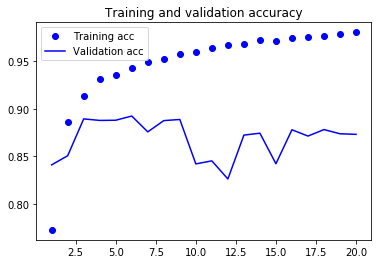

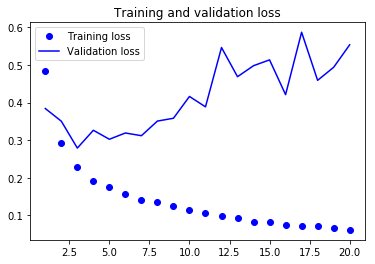

In [9]:
show_plots(history.history['acc'],
          history.history['val_acc'],
          history.history['loss'],
          history.history['val_loss'])

Let's try a bidirectional LSTM

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 148s 7ms/step - loss: 0.5072 - acc: 0.7616 - val_loss: 0.3834 - val_acc: 0.8484
Epoch 2/10
20000/20000 [==============================] - 145s 7ms/step - loss: 0.2952 - acc: 0.8842 - val_loss: 0.2812 - val_acc: 0.8862
Epoch 3/10
20000/20000 [==============================] - 145s 7ms/step - loss: 0.2333 - acc: 0.9115 - val_loss: 0.3973 - val_acc: 0.8694
Epoch 4/10
20000/20000 [==============================] - 145s 7ms/step - loss: 0.2029 - acc: 0.9250 - val_loss: 0.2821 - val_acc: 0.8912
Epoch 5/10
20000/20000 [==============================] - 145s 7ms/step - loss: 0.1768 - acc: 0.9339 - val_loss: 0.3071 - val_acc: 0.8832
Epoch 6/10
20000/20000 [==============================] - 144s 7ms/step - loss: 0.1554 - acc: 0.9447 - val_loss: 0.3349 - val_acc: 0.8842
Epoch 7/10
20000/20000 [==============================] - 144s 7ms/step - loss: 0.1445 - acc: 0.9497 - val_loss: 0.3356 - v

In [ ]:
show_plots(history.history['acc'],
          history.history['val_acc'],
          history.history['loss'],
          history.history['val_loss'])

## Temperature forecasting problem
Let's now consider a non natural language processing problem making use of sequence data- specifically a weather timeseries dataset. In this dataset, 14 different quantities (e.g. air temperature, atmospheric pressure, humidity etc.) were measures every **10 minutes** We'll build a model that takes as input the last few days of weather data and uses it to predict the air temperature 24 hours in the future.

In [36]:
import os
DATA_DIR = './jena_climate'
fname = os.path.join(DATA_DIR, 'jena_climate_2009_2016.csv')
# read in the raw data
with open(fname) as f:
    data = f.read()
# split the lines using newline characters
lines = data.split('\n')
# identify variables and separate out the header
header = lines[0].split(',')
lines = lines[1:]

print(f'Temperature data header: {header}')
print(f'Temperature data observations: {len(lines)}')

Temperature data header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Temperature data observations: 420551


Now let's create a Numpy array of the actual data values, which we'll use for training:

In [37]:
import numpy as np
from tqdm import tqdm
# create a placeholder numpy array of zeros
# nrows = number of weather variable observations from 2009 to 2016
# ncols = number of weather variables
float_data = np.zeros((len(lines), len(header)-1))
pbar = tqdm(range(len(lines)))
for i, line in enumerate(lines):
    # cast weather variables to float types (exclusing the time index)
    values = [float(x) for x in line.split(',')[1:]]
    # fill in the relevant placeholder row with the variables
    float_data[i, :] = values
    pbar.update()
pbar.close()

100%|██████████| 420551/420551 [00:02<00:00, 170067.90it/s]


Using the Numpy array we can now visualize the temperature data across the entire data set:

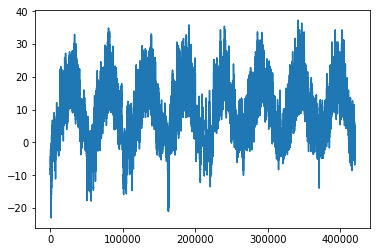

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

# extract the temperature
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp);

We could benefit from some finer detail- let's take a look at the data for the first ten days. Since a measurement is recorded every 10 minutes, there are 144 observations per day. We'd expect to see some clear periodicity in evidence.

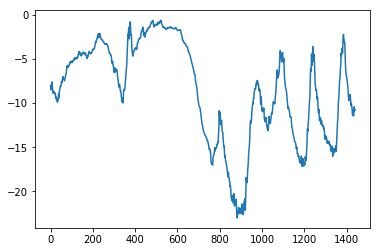

In [39]:
plt.plot(range(1440), temp[:1440]);

### Preparing the data

Let's take a look at preparing the data for modelling. Firstly, we need to define the sequences of observations with which we'll be working, as well as the target we'll be predicting. For this we'll needs some specific parameters:
* `lookback = 720` - observations will go back 5 days in the past
* `steps = 6` - observations will be sampled at the rate of one data point per hour (downsampling)
* `delay = 144` - the target for prediction will be 24 hours in future
We'll also need to standardize the scale of the data for the different climate variables. As you'll see below, the different variables have very different ranges, which complicates the training process for a neural network. A common way to scale data is to subtract the mean of each variable, and divide each variables by its standard deviation.

In [27]:
import pandas as pd
weather_df = pd.read_csv(fname)
weather_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [28]:
print(f'Weather minima:\n', weather_df.min(), '\n')
print(f'Weather maxima:\n', weather_df.max())

Weather minima:
 Date Time          01.01.2009 00:10:00
p (mbar)                         913.6
T (degC)                        -23.01
Tpot (K)                         250.6
Tdew (degC)                     -25.01
rh (%)                           12.95
VPmax (mbar)                      0.95
VPact (mbar)                      0.79
VPdef (mbar)                         0
sh (g/kg)                          0.5
H2OC (mmol/mol)                    0.8
rho (g/m**3)                   1059.45
wv (m/s)                         -9999
max. wv (m/s)                    -9999
wd (deg)                             0
dtype: object 

Weather maxima:
 Date Time          31.12.2016 23:50:00
p (mbar)                       1015.35
T (degC)                         37.28
Tpot (K)                        311.34
Tdew (degC)                      23.11
rh (%)                             100
VPmax (mbar)                     63.77
VPact (mbar)                     28.32
VPdef (mbar)                     46.01
sh (g/kg)     

In [40]:
# performing normalization on the Numpy array
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now we consider actually creating the training data in its final form for our recurrent model. Because adjacent inputs in time have many observations in common, creating a generator object to return data on the fly is the most efficient approach (or the approach with the least redundancy).

In [41]:
def data_generator(data, lookback, delay, min_index, max_index, 
                  shuffle=False, batch_size=128, step=6):
    """
    :data array: parent Numpy array from which to derive data
    :lookback int: number of timesteps in the past to consider for input
    :delay int: number of timesteps in the future for targets
    :min_index int: min index to draw data from in parent array
    :max_index int: max index to draw data from in parent array
    """
    if max_index is None:
        # the maximum integer index for data is len(data) - 1
        # we can train for an index of at most len(data) - delay - 1
        max_index = len(data) - delay - 1
    # we can't lookback past the min index
    i = min_index + lookback
    while True:
        if shuffle:
            # choose random integer indices for batch within bounds
            rows = np.random.randint(min_index+lookback, max_index,
                                    size=batch_size)
        else:
            # if the batch would over-run the last index, reset it to the start
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            # create a subsampling every step timesteps from index rows[j] - lookback 
            # to the current time step rows[j]
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            

In [45]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = data_generator(float_data,
                          lookback=lookback, 
                          delay=delay,
                          min_index=0,
                          max_index=200000,
                          shuffle=True,
                          step=step,
                          batch_size=batch_size)
val_gen = data_generator(float_data,
                          lookback=lookback, 
                          delay=delay,
                          min_index=200001,
                          max_index=300000,
                          step=step,
                          batch_size=batch_size)
test_gen = data_generator(float_data,
                          lookback=lookback, 
                          delay=delay,
                          min_index=300001,
                          max_index=None,
                          step=step,
                          batch_size=batch_size)
# define number of steps to draw from val_gen to see the entire validation set
train_steps = (200000 - lookback) // batch_size
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

Here we define a common sense baseline of predicting that the temperature today will be equal to the current temperature. We'll evaluate this approach using mean absolute error (MAE).

In [43]:
def evaluate_naive_prediction():
    """
    Evaluate baseline heuristic for prediction: predict the temperature in 24 hours
    to be the same as the current temperature.
    """
    batch_maes = []
    with tqdm(range(val_steps)) as pbar:
        for step in range(val_steps):
            samples, targets = next(val_gen)
            preds = samples[:, -1, 1]
            mae = np.mean(np.abs(preds - targets))
            batch_maes.append(mae)
            pbar.update()
    print(f'Mean MAE: {np.mean(batch_maes)}')
evaluate_naive_prediction()

100%|██████████| 96/96 [00:04<00:00, 22.74it/s]

Mean MAE: 0.2899222277291266


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard

model = Sequential()
model.add(layers.LSTM(32,
         dropout=0.1,
         recurrent_dropout=0.5,
         return_sequences=True,
         input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=50,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps,
                             callbacks = [TensorBoard(log_dir='./logs/temperature_default')])

In [46]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks = [TensorBoard(log_dir='./logs/temperature_gru')])

Epoch 1/20
500/500 [==============================] - 117s 235ms/step - loss: 0.3185 - val_loss: 0.2698
Epoch 2/20
500/500 [==============================] - 116s 233ms/step - loss: 0.2858 - val_loss: 0.2736
Epoch 3/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2785 - val_loss: 0.2692
Epoch 4/20
500/500 [==============================] - 117s 233ms/step - loss: 0.2713 - val_loss: 0.2666
Epoch 5/20
500/500 [==============================] - 117s 233ms/step - loss: 0.2678 - val_loss: 0.2646
Epoch 6/20
500/500 [==============================] - 115s 230ms/step - loss: 0.2608 - val_loss: 0.2667
Epoch 7/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2560 - val_loss: 0.2764
Epoch 8/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2523 - val_loss: 0.2784
Epoch 9/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2476 - val_loss: 0.2783
Epoch 10/20
500/500 [==============================] - 112s 223m

In [47]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks = [TensorBoard(log_dir='./logs/temperature_gru_dropout')])

Epoch 1/40
500/500 [==============================] - 138s 276ms/step - loss: 0.3394 - val_loss: 0.2768
Epoch 2/40
500/500 [==============================] - 129s 257ms/step - loss: 0.3144 - val_loss: 0.2736
Epoch 3/40
500/500 [==============================] - 127s 254ms/step - loss: 0.3085 - val_loss: 0.2714
Epoch 4/40
500/500 [==============================] - 127s 254ms/step - loss: 0.3057 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 127s 254ms/step - loss: 0.3005 - val_loss: 0.2659
Epoch 6/40
500/500 [==============================] - 127s 254ms/step - loss: 0.2982 - val_loss: 0.2684
Epoch 7/40
500/500 [==============================] - 123s 245ms/step - loss: 0.2949 - val_loss: 0.2679
Epoch 8/40
500/500 [==============================] - 123s 245ms/step - loss: 0.2935 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 123s 246ms/step - loss: 0.2918 - val_loss: 0.2675
Epoch 10/40
500/500 [==============================] - 123s 245m